In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### dataset information

In [4]:
from datetime import datetime

dataset = "cifar10"
dims = (32, 32, 3)
num_classes = 10
labels_per_class = 128 # full
batch_size = 128
datestring = datetime.now().strftime("%Y_%m_%d_%H_%M_%S_%f")
datestring = (
    str(dataset)
    + "_"
    + str(labels_per_class)
    + "____"
    + datestring 
    + '_baseline'
)
print(datestring)

cifar10_128____2020_08_09_21_58_00_869329_baseline


### Load packages

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [6]:
from tfumap.load_datasets import load_CIFAR10, mask_labels
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_CIFAR10(flatten=False)
X_train.shape

(40000, 32, 32, 3)

In [7]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_masked = Y_labeled = Y_train
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

### Build network

In [8]:
from tensorflow.keras import datasets, layers, models
from tensorflow_addons.layers import WeightNormalization

def conv_block(filts, name, kernel_size = (3, 3), padding = "same", **kwargs):
    return WeightNormalization(
        layers.Conv2D(
            filts, kernel_size, activation=None, padding=padding, **kwargs
        ),
        name="conv"+name,
    )
#CNN13
#See: 
#https://github.com/vikasverma1077/ICT/blob/master/networks/lenet.py
#https://github.com/brain-research/realistic-ssl-evaluation

In [9]:

lr_alpha = 0.1
dropout_rate = 0.5
num_classes = 10
input_shape = (32, 32, 3)
model = models.Sequential()
model.add(tf.keras.Input(shape=input_shape))
### conv1a
name = '1a'
model.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv1b
name = '1b'
model.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv1c
name = '1c'
model.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name="mp1"))
# dropout
model.add(layers.Dropout(dropout_rate, name="drop1"))

### conv2a
name = '2a'
model.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha))

### conv2b
name = '2b'
model.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv2c
name = '2c'
model.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name="mp2"))
# dropout
model.add(layers.Dropout(dropout_rate, name="drop2"))

### conv3a
name = '3a'
model.add(conv_block(name = name, filts = 512, kernel_size = (3,3), padding="valid"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv3b
name = '3b'
model.add(conv_block(name = name, filts = 256, kernel_size = (1,1), padding="valid"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv3c
name = '3c'
model.add(conv_block(name = name, filts = 128, kernel_size = (1,1), padding="valid"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
model.add(layers.AveragePooling2D(pool_size=(6, 6), strides=2, padding='valid'))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation=None, name='z'))
model.add(WeightNormalization(layers.Dense(256, activation=None)))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelufc1'))
model.add(WeightNormalization(layers.Dense(256, activation=None)))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelufc2'))
model.add(WeightNormalization(layers.Dense(num_classes, activation=None)))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1a (WeightNormalization) (None, 32, 32, 128)       7297      
_________________________________________________________________
bn1a (BatchNormalization)    (None, 32, 32, 128)       512       
_________________________________________________________________
lrelu1a (LeakyReLU)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv1b (WeightNormalization) (None, 32, 32, 128)       295297    
_________________________________________________________________
bn1b (BatchNormalization)    (None, 32, 32, 128)       512       
_________________________________________________________________
lrelu1b (LeakyReLU)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv1c (WeightNormalization) (None, 32, 32, 128)       2

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=50, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

In [12]:
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2, from_logits=True)

In [13]:
model.compile(tf.keras.optimizers.Adam(1e-4), loss = loss, metrics=['accuracy'])

In [14]:
Y_valid_one_hot = tf.keras.backend.one_hot(
    Y_valid, num_classes
)

In [15]:
Y_labeled_one_hot = tf.keras.backend.one_hot(
    Y_labeled, num_classes
)

In [16]:
history = model.fit(
    X_labeled,
    Y_labeled_one_hot,
    batch_size=batch_size,
    epochs=500,
    validation_data=(X_valid, Y_valid_one_hot),
    callbacks = [early_stopping]
)

Epoch 1/500
 2/10 [=====>........................] - ETA: 0s - loss: 2.4737 - accuracy: 0.1523

W0809 21:58:16.911067 140150174160704 callbacks.py:328] Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0194s vs `on_train_batch_end` time: 0.0655s). Check your callbacks.


10/10 [==============================] - 5s 525ms/step - loss: 2.3661 - accuracy: 0.1766 - val_loss: 11.9076 - val_accuracy: 0.1046
Epoch 2/500
10/10 [==============================] - 4s 391ms/step - loss: 2.1640 - accuracy: 0.2594 - val_loss: 9.6057 - val_accuracy: 0.1272
Epoch 3/500
10/10 [==============================] - 4s 400ms/step - loss: 2.0916 - accuracy: 0.2914 - val_loss: 4.1683 - val_accuracy: 0.1708
Epoch 4/500
10/10 [==============================] - 4s 394ms/step - loss: 2.0073 - accuracy: 0.3484 - val_loss: 3.2572 - val_accuracy: 0.2320
Epoch 5/500
10/10 [==============================] - 4s 382ms/step - loss: 1.9831 - accuracy: 0.3531 - val_loss: 2.9262 - val_accuracy: 0.2387
Epoch 6/500
10/10 [==============================] - 4s 368ms/step - loss: 1.9517 - accuracy: 0.3688 - val_loss: 3.0412 - val_accuracy: 0.2481
Epoch 7/500
10/10 [==============================] - 4s 388ms/step - loss: 1.8970 - accuracy: 0.4023 - val_loss: 3.2719 - val_accuracy: 0.2392
Epoch 8/50

10/10 [==============================] - 4s 391ms/step - loss: 1.1076 - accuracy: 0.9391 - val_loss: 2.7102 - val_accuracy: 0.3411
Epoch 59/500
10/10 [==============================] - 4s 393ms/step - loss: 1.1047 - accuracy: 0.9430 - val_loss: 2.5641 - val_accuracy: 0.3627
Epoch 60/500
10/10 [==============================] - 4s 386ms/step - loss: 1.0953 - accuracy: 0.9508 - val_loss: 2.6452 - val_accuracy: 0.3593
Epoch 61/500
10/10 [==============================] - 4s 388ms/step - loss: 1.0949 - accuracy: 0.9531 - val_loss: 2.5522 - val_accuracy: 0.3623
Epoch 62/500
10/10 [==============================] - 4s 367ms/step - loss: 1.0988 - accuracy: 0.9383 - val_loss: 2.6555 - val_accuracy: 0.3473
Epoch 63/500
10/10 [==============================] - 4s 387ms/step - loss: 1.0775 - accuracy: 0.9617 - val_loss: 2.6378 - val_accuracy: 0.3423
Epoch 64/500
10/10 [==============================] - 4s 389ms/step - loss: 1.0851 - accuracy: 0.9563 - val_loss: 2.6863 - val_accuracy: 0.3461
Epoch

Epoch 115/500
10/10 [==============================] - 4s 397ms/step - loss: 0.9545 - accuracy: 0.9984 - val_loss: 2.3136 - val_accuracy: 0.3928
Epoch 116/500
10/10 [==============================] - 4s 383ms/step - loss: 0.9584 - accuracy: 0.9969 - val_loss: 2.2965 - val_accuracy: 0.3928
Epoch 117/500
10/10 [==============================] - 4s 380ms/step - loss: 0.9542 - accuracy: 0.9992 - val_loss: 2.3455 - val_accuracy: 0.3968
Epoch 118/500
10/10 [==============================] - 4s 392ms/step - loss: 0.9525 - accuracy: 0.9992 - val_loss: 2.2541 - val_accuracy: 0.4094
Epoch 119/500
10/10 [==============================] - 4s 372ms/step - loss: 0.9549 - accuracy: 1.0000 - val_loss: 2.2756 - val_accuracy: 0.4137
Epoch 120/500
10/10 [==============================] - 4s 368ms/step - loss: 0.9543 - accuracy: 0.9977 - val_loss: 2.2755 - val_accuracy: 0.4003
Epoch 121/500
10/10 [==============================] - 4s 388ms/step - loss: 0.9452 - accuracy: 0.9992 - val_loss: 2.3042 - val_ac

10/10 [==============================] - 4s 393ms/step - loss: 0.9281 - accuracy: 1.0000 - val_loss: 2.1454 - val_accuracy: 0.4375
Epoch 172/500
10/10 [==============================] - 4s 389ms/step - loss: 0.9305 - accuracy: 0.9992 - val_loss: 2.1459 - val_accuracy: 0.4356
Epoch 173/500
10/10 [==============================] - 4s 395ms/step - loss: 0.9223 - accuracy: 1.0000 - val_loss: 2.1223 - val_accuracy: 0.4428
Epoch 174/500
10/10 [==============================] - 4s 385ms/step - loss: 0.9226 - accuracy: 1.0000 - val_loss: 2.1194 - val_accuracy: 0.4453
Epoch 175/500
10/10 [==============================] - 4s 390ms/step - loss: 0.9209 - accuracy: 1.0000 - val_loss: 2.0792 - val_accuracy: 0.4535
Epoch 176/500
10/10 [==============================] - 4s 362ms/step - loss: 0.9268 - accuracy: 0.9992 - val_loss: 2.1054 - val_accuracy: 0.4472
Epoch 177/500
10/10 [==============================] - 4s 393ms/step - loss: 0.9276 - accuracy: 1.0000 - val_loss: 2.1853 - val_accuracy: 0.4263

10/10 [==============================] - 4s 387ms/step - loss: 0.9153 - accuracy: 0.9992 - val_loss: 2.0474 - val_accuracy: 0.4520
Epoch 228/500
10/10 [==============================] - 4s 393ms/step - loss: 0.9092 - accuracy: 1.0000 - val_loss: 2.0611 - val_accuracy: 0.4455
Epoch 229/500
10/10 [==============================] - 4s 395ms/step - loss: 0.9106 - accuracy: 1.0000 - val_loss: 2.0526 - val_accuracy: 0.4547
Epoch 230/500
10/10 [==============================] - 4s 393ms/step - loss: 0.9106 - accuracy: 1.0000 - val_loss: 2.0732 - val_accuracy: 0.4461
Epoch 231/500
10/10 [==============================] - 4s 386ms/step - loss: 0.9092 - accuracy: 1.0000 - val_loss: 2.0797 - val_accuracy: 0.4450
Epoch 232/500
10/10 [==============================] - 4s 386ms/step - loss: 0.9097 - accuracy: 1.0000 - val_loss: 2.1292 - val_accuracy: 0.4358
Epoch 233/500
10/10 [==============================] - 4s 352ms/step - loss: 0.9109 - accuracy: 1.0000 - val_loss: 2.0562 - val_accuracy: 0.4490

10/10 [==============================] - 8s 835ms/step - loss: 0.9022 - accuracy: 1.0000 - val_loss: 1.9685 - val_accuracy: 0.4717
Epoch 284/500
10/10 [==============================] - 9s 883ms/step - loss: 0.9010 - accuracy: 1.0000 - val_loss: 1.9733 - val_accuracy: 0.4718
Epoch 285/500
10/10 [==============================] - 9s 894ms/step - loss: 0.9027 - accuracy: 1.0000 - val_loss: 1.9847 - val_accuracy: 0.4701
Epoch 286/500
10/10 [==============================] - 9s 860ms/step - loss: 0.9050 - accuracy: 1.0000 - val_loss: 1.9760 - val_accuracy: 0.4687
Epoch 287/500
10/10 [==============================] - 9s 910ms/step - loss: 0.9016 - accuracy: 1.0000 - val_loss: 1.9920 - val_accuracy: 0.4710
Epoch 288/500
10/10 [==============================] - 8s 836ms/step - loss: 0.9011 - accuracy: 1.0000 - val_loss: 1.9760 - val_accuracy: 0.4717
Epoch 289/500
10/10 [==============================] - 9s 906ms/step - loss: 0.9025 - accuracy: 1.0000 - val_loss: 2.0183 - val_accuracy: 0.4609

10/10 [==============================] - 9s 878ms/step - loss: 0.8964 - accuracy: 1.0000 - val_loss: 1.9790 - val_accuracy: 0.4638
Epoch 340/500
10/10 [==============================] - 9s 857ms/step - loss: 0.8972 - accuracy: 1.0000 - val_loss: 1.9554 - val_accuracy: 0.4740
Epoch 341/500
10/10 [==============================] - 9s 856ms/step - loss: 0.8963 - accuracy: 1.0000 - val_loss: 1.9472 - val_accuracy: 0.4782
Epoch 342/500
10/10 [==============================] - 9s 877ms/step - loss: 0.8968 - accuracy: 1.0000 - val_loss: 1.9229 - val_accuracy: 0.4827
Epoch 343/500
10/10 [==============================] - 8s 807ms/step - loss: 0.8967 - accuracy: 1.0000 - val_loss: 1.9439 - val_accuracy: 0.4755
Epoch 344/500
10/10 [==============================] - 9s 902ms/step - loss: 0.8983 - accuracy: 1.0000 - val_loss: 1.9343 - val_accuracy: 0.4810
Epoch 345/500
10/10 [==============================] - 9s 888ms/step - loss: 0.8965 - accuracy: 1.0000 - val_loss: 1.9373 - val_accuracy: 0.4796

10/10 [==============================] - 7s 744ms/step - loss: 0.8917 - accuracy: 1.0000 - val_loss: 1.9000 - val_accuracy: 0.4851
Epoch 396/500
10/10 [==============================] - 7s 705ms/step - loss: 0.8927 - accuracy: 1.0000 - val_loss: 1.9147 - val_accuracy: 0.4779
Epoch 397/500
10/10 [==============================] - 7s 709ms/step - loss: 0.8922 - accuracy: 1.0000 - val_loss: 1.9152 - val_accuracy: 0.4847
Epoch 398/500
10/10 [==============================] - 7s 705ms/step - loss: 0.8913 - accuracy: 1.0000 - val_loss: 1.9419 - val_accuracy: 0.4661
Epoch 399/500
10/10 [==============================] - 7s 717ms/step - loss: 0.8917 - accuracy: 1.0000 - val_loss: 1.9190 - val_accuracy: 0.4812
Epoch 400/500
10/10 [==============================] - 7s 747ms/step - loss: 0.8937 - accuracy: 1.0000 - val_loss: 1.9212 - val_accuracy: 0.4783
Epoch 401/500
10/10 [==============================] - 7s 704ms/step - loss: 0.8921 - accuracy: 1.0000 - val_loss: 1.9253 - val_accuracy: 0.4821

10/10 [==============================] - 7s 729ms/step - loss: 0.8879 - accuracy: 1.0000 - val_loss: 1.8926 - val_accuracy: 0.4819
Epoch 452/500
10/10 [==============================] - 7s 731ms/step - loss: 0.8868 - accuracy: 1.0000 - val_loss: 1.9073 - val_accuracy: 0.4821
Epoch 453/500
10/10 [==============================] - 7s 749ms/step - loss: 0.8859 - accuracy: 1.0000 - val_loss: 1.9071 - val_accuracy: 0.4790
Epoch 454/500
10/10 [==============================] - 7s 675ms/step - loss: 0.8876 - accuracy: 1.0000 - val_loss: 1.8900 - val_accuracy: 0.4859
Epoch 455/500
10/10 [==============================] - 7s 715ms/step - loss: 0.8884 - accuracy: 1.0000 - val_loss: 1.8894 - val_accuracy: 0.4810
Epoch 456/500
10/10 [==============================] - 7s 697ms/step - loss: 0.8901 - accuracy: 1.0000 - val_loss: 1.9109 - val_accuracy: 0.4790
Epoch 457/500
10/10 [==============================] - 8s 753ms/step - loss: 0.8882 - accuracy: 1.0000 - val_loss: 1.8875 - val_accuracy: 0.4885

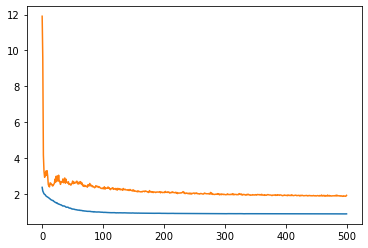

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

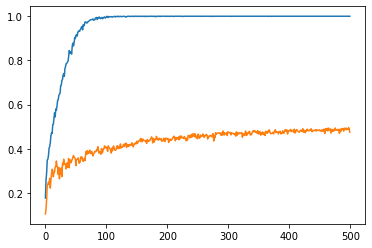

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [19]:
submodel = tf.keras.models.Model(
        [model.inputs[0]], [model.get_layer('z').output]
    )
z = submodel.predict(X_train)
np.shape(z)

(40000, 256)

In [20]:
reducer = umap.UMAP(verbose=True)

embedding = reducer.fit_transform(z.reshape(len(z), np.product(np.shape(z)[1:])))

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Sun Aug  9 22:48:03 2020 Finding Nearest Neighbors
Sun Aug  9 22:48:03 2020 Building RP forest with 15 trees
Sun Aug  9 22:48:05 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
Sun Aug  9 22:48:15 2020 Finished Nearest Neighbor Search
Sun Aug  9 22:48:18 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Aug  9 22:48:44 2020 Finished embedding


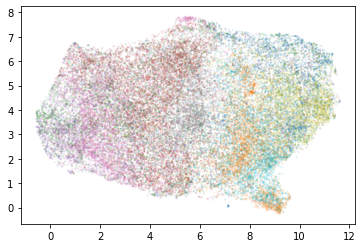

In [21]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=Y_train.flatten(), s= 1, alpha = 0.1, cmap = plt.cm.tab10)

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Sun Aug  9 22:48:53 2020 Finding Nearest Neighbors
Sun Aug  9 22:48:53 2020 Building RP forest with 10 trees
Sun Aug  9 22:48:53 2020 parallel NN descent for 13 iterations
	 0  /  13
	 1  /  13
	 2  /  13
	 3  /  13
Sun Aug  9 22:48:54 2020 Finished Nearest Neighbor Search
Sun Aug  9 22:48:54 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sun Aug  9 22:49:12 2020 Finished embedding


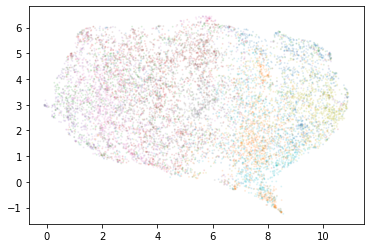

In [22]:
z_valid = submodel.predict(X_valid)
np.shape(z_valid)
reducer = umap.UMAP(verbose=True)

valid_embedding = reducer.fit_transform(z_valid.reshape(len(z_valid), np.product(np.shape(z_valid)[1:])))

plt.scatter(valid_embedding[:, 0], valid_embedding[:, 1], c=Y_valid.flatten(), s= 1, alpha = 0.1, cmap = plt.cm.tab10)

### save results

In [ ]:
# save score, valid embedding, weights, results

In [46]:
from tfumap.paths import MODEL_DIR, ensure_dir

In [48]:
save_folder = MODEL_DIR / 'semisupervised-keras' / dataset / str(labels_per_class) / datestring
ensure_dir(save_folder)

#### save weights

In [60]:
encoder = tf.keras.models.Model(
        [model.inputs[0]], [model.get_layer('z').output]
)

In [62]:
encoder.save_weights((save_folder / "encoder").as_posix())

In [41]:
classifier = tf.keras.models.Model(
        [tf.keras.Input(tensor=model.get_layer('weight_normalization').input)], [model.outputs[0]]
)
print([i.name for i in classifier.layers])

['input_3', 'weight_normalization', 'lrelufc1', 'weight_normalization_1', 'lrelufc2', 'weight_normalization_2']


In [63]:
classifier.save_weights((save_folder / "classifier").as_posix())

#### save score

In [43]:
Y_test_one_hot = tf.keras.backend.one_hot(
    Y_test, num_classes
)
result = model.evaluate(X_test, Y_test_one_hot)

313/313 [==============================] - 9s 29ms/step - loss: 1.9136 - accuracy: 0.4693


In [49]:
np.save(save_folder / 'test_loss.npy', result)

#### save embedding

In [56]:
z = embedder.predict(X_train)

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Sun Aug  9 23:24:31 2020 Finding Nearest Neighbors
Sun Aug  9 23:24:31 2020 Building RP forest with 15 trees
Sun Aug  9 23:24:31 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
Sun Aug  9 23:24:32 2020 Finished Nearest Neighbor Search
Sun Aug  9 23:24:33 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Aug  9 23:24:58 2020 Finished embedding


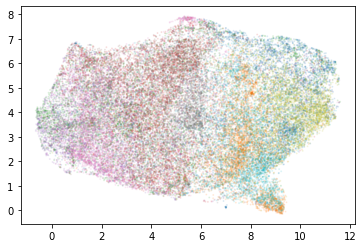

In [58]:
reducer = umap.UMAP(verbose=True)

embedding = reducer.fit_transform(z.reshape(len(z), np.product(np.shape(z)[1:])))

plt.scatter(embedding[:, 0], embedding[:, 1], c=Y_train.flatten(), s= 1, alpha = 0.1, cmap = plt.cm.tab10)

In [64]:
np.save(save_folder / 'train_embedding.npy', embedding)

#### save results

In [66]:
import pickle

In [67]:
with open(save_folder / 'history.pickle', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)